

---

## **Install conda and rdkit**

In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2024-06-22 14:34:00--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M  76.0MB/s    in 1.1s    

2024-06-22 14:34:01 (76.0 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=

## **Load bioactivity data**

In [61]:
url = "https://raw.githubusercontent.com/az09tuan/PLK1/main/bioactivity_data_preprocessed-PLK1.csv"

In [62]:
import pandas as pd

In [63]:
df = pd.read_csv(url)

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

### **Import libraries**

In [5]:
!pip uninstall rdkit -y
!pip install rdkit-pypi

     |████████████████████████████████| 29.2 MB 72.9 MB/s 


In [6]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [7]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [8]:
import numpy as np

print(df.SMILE.dtypes)  # Check the data type of the column
print(df.SMILE.isna().sum())  # Check for missing values
print(df.SMILE[~df.SMILE.apply(isinstance, args=(str,))].head())  # Check for non-string values

object
0
Series([], Name: SMILE, dtype: object)


In [9]:
# Remove rows with non-string or missing values
df = df[df.SMILE.apply(isinstance, args=(str,))]


In [10]:
df_lipinski = lipinski(df.SMILE)

### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [11]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,521.666,3.55680,2.0,8.0
1,561.666,4.31888,2.0,10.0
2,527.607,4.25910,2.0,12.0
3,552.661,3.93630,2.0,12.0
4,521.534,3.11790,2.0,11.0
...,...,...,...,...
3243,399.556,6.39812,2.0,3.0
3244,554.655,4.39930,2.0,8.0
3245,383.488,5.54870,2.0,3.0
3246,459.593,5.72368,0.0,4.0


In [12]:
df

,SMILE,IC50,Source,bioactivity_class
0,CC[C@@H]1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=...,0.083,Pubchem,active
1,CC[C@@H]1C2=C(N=CN2C3=CN=C(N=C3N1C(C)C)NC4=C(C...,0.400,Pubchem,active
2,CN(C)C1CCN(CC1)C2=CC(=C(C=C2)NC3=NC=C(C(=N3)NC...,0.508,Pubchem,active
3,CN1CCN(CC1)C2CCN(CC2)C3=CC=C(C=C3)NC4=NC=C(C(=...,0.508,Pubchem,active
4,CN(C)CC(=O)N1CCC2=CC(=C(C=C21)NC3=NC=C(C(=N3)N...,0.508,Pubchem,active
...,...,...,...,...
3243,CCCCCCCCSc1ccc(C(=O)Nc2ccc(C)cc2C(=O)O)cc1,26800.000,CHEMBL,inactive
3244,CC[C@@H]1C(=O)N(C)c2cnc(N(C)c3ccc(-c4nc5c(C(N)...,2028.000,CHEMBL,intermediate
3245,CCCCCCCCc1ccc(C(=O)Nc2ccc(OC)cc2C(=O)O)cc1,5900.000,CHEMBL,intermediate
3246,C[C@@]12CN(Cc3cccc(C#N)c3)C[C@@](C)(C1)c1c(-c3...,17900.000,CHEMBL,inactive


Now, let's combine the 2 DataFrame

In [13]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [14]:
df_combined

,SMILE,IC50,Source,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CC[C@@H]1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=...,0.083,Pubchem,active,521.666,3.55680,2.0,8.0
1,CC[C@@H]1C2=C(N=CN2C3=CN=C(N=C3N1C(C)C)NC4=C(C...,0.400,Pubchem,active,561.666,4.31888,2.0,10.0
2,CN(C)C1CCN(CC1)C2=CC(=C(C=C2)NC3=NC=C(C(=N3)NC...,0.508,Pubchem,active,527.607,4.25910,2.0,12.0
3,CN1CCN(CC1)C2CCN(CC2)C3=CC=C(C=C3)NC4=NC=C(C(=...,0.508,Pubchem,active,552.661,3.93630,2.0,12.0
4,CN(C)CC(=O)N1CCC2=CC(=C(C=C21)NC3=NC=C(C(=N3)N...,0.508,Pubchem,active,521.534,3.11790,2.0,11.0
...,...,...,...,...,...,...,...,...
3243,CCCCCCCCSc1ccc(C(=O)Nc2ccc(C)cc2C(=O)O)cc1,26800.000,CHEMBL,inactive,399.556,6.39812,2.0,3.0
3244,CC[C@@H]1C(=O)N(C)c2cnc(N(C)c3ccc(-c4nc5c(C(N)...,2028.000,CHEMBL,intermediate,554.655,4.39930,2.0,8.0
3245,CCCCCCCCc1ccc(C(=O)Nc2ccc(OC)cc2C(=O)O)cc1,5900.000,CHEMBL,intermediate,383.488,5.54870,2.0,3.0
3246,C[C@@]12CN(Cc3cccc(C#N)c3)C[C@@](C)(C1)c1c(-c3...,17900.000,CHEMBL,inactive,459.593,5.72368,0.0,4.0


In [15]:
df_combined.to_csv('df_combined_lipinski.csv', index=False)

### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [16]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)

    return x

In [17]:
df_combined.IC50.describe()

count      3248.000000
mean      16577.261601
std       55924.316489
min           0.083000
25%          44.000000
50%        1060.000000
75%        9000.000000
max      600000.000000
Name: IC50, dtype: float64

In [18]:
-np.log10( (10**-9)* 100000000 )

1.0

In [19]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [20]:
def norm_value(input):
    norm = [] # initialize an empty list to store normalized values

    for i in input['IC50']:
        if i > 100000000:
          i = 100000000
        norm.append(i) # append the normalized value to the list

    input['standard_value_norm'] = norm # create a new column in the dataframe for normalized values
    x = input.drop('IC50', axis=1) # drop the original 'IC50' column

    return x # return modified dataframe

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [21]:
df_norm = norm_value(df_combined)
df_norm

,SMILE,Source,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CC[C@@H]1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=...,Pubchem,active,521.666,3.55680,2.0,8.0,0.083
1,CC[C@@H]1C2=C(N=CN2C3=CN=C(N=C3N1C(C)C)NC4=C(C...,Pubchem,active,561.666,4.31888,2.0,10.0,0.400
2,CN(C)C1CCN(CC1)C2=CC(=C(C=C2)NC3=NC=C(C(=N3)NC...,Pubchem,active,527.607,4.25910,2.0,12.0,0.508
3,CN1CCN(CC1)C2CCN(CC2)C3=CC=C(C=C3)NC4=NC=C(C(=...,Pubchem,active,552.661,3.93630,2.0,12.0,0.508
4,CN(C)CC(=O)N1CCC2=CC(=C(C=C21)NC3=NC=C(C(=N3)N...,Pubchem,active,521.534,3.11790,2.0,11.0,0.508
...,...,...,...,...,...,...,...,...
3243,CCCCCCCCSc1ccc(C(=O)Nc2ccc(C)cc2C(=O)O)cc1,CHEMBL,inactive,399.556,6.39812,2.0,3.0,26800.000
3244,CC[C@@H]1C(=O)N(C)c2cnc(N(C)c3ccc(-c4nc5c(C(N)...,CHEMBL,intermediate,554.655,4.39930,2.0,8.0,2028.000
3245,CCCCCCCCc1ccc(C(=O)Nc2ccc(OC)cc2C(=O)O)cc1,CHEMBL,intermediate,383.488,5.54870,2.0,3.0,5900.000
3246,C[C@@]12CN(Cc3cccc(C#N)c3)C[C@@](C)(C1)c1c(-c3...,CHEMBL,inactive,459.593,5.72368,0.0,4.0,17900.000


In [22]:
df_norm.standard_value_norm.describe()

count      3248.000000
mean      16577.261601
std       55924.316489
min           0.083000
25%          44.000000
50%        1060.000000
75%        9000.000000
max      600000.000000
Name: standard_value_norm, dtype: float64

In [23]:
df_final = pIC50(df_norm)
df_final

,SMILE,Source,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CC[C@@H]1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=...,Pubchem,active,521.666,3.55680,2.0,8.0,10.080922
1,CC[C@@H]1C2=C(N=CN2C3=CN=C(N=C3N1C(C)C)NC4=C(C...,Pubchem,active,561.666,4.31888,2.0,10.0,9.397940
2,CN(C)C1CCN(CC1)C2=CC(=C(C=C2)NC3=NC=C(C(=N3)NC...,Pubchem,active,527.607,4.25910,2.0,12.0,9.294136
3,CN1CCN(CC1)C2CCN(CC2)C3=CC=C(C=C3)NC4=NC=C(C(=...,Pubchem,active,552.661,3.93630,2.0,12.0,9.294136
4,CN(C)CC(=O)N1CCC2=CC(=C(C=C21)NC3=NC=C(C(=N3)N...,Pubchem,active,521.534,3.11790,2.0,11.0,9.294136
...,...,...,...,...,...,...,...,...
3243,CCCCCCCCSc1ccc(C(=O)Nc2ccc(C)cc2C(=O)O)cc1,CHEMBL,inactive,399.556,6.39812,2.0,3.0,4.571865
3244,CC[C@@H]1C(=O)N(C)c2cnc(N(C)c3ccc(-c4nc5c(C(N)...,CHEMBL,intermediate,554.655,4.39930,2.0,8.0,5.692932
3245,CCCCCCCCc1ccc(C(=O)Nc2ccc(OC)cc2C(=O)O)cc1,CHEMBL,intermediate,383.488,5.54870,2.0,3.0,5.229148
3246,C[C@@]12CN(Cc3cccc(C#N)c3)C[C@@](C)(C1)c1c(-c3...,CHEMBL,inactive,459.593,5.72368,0.0,4.0,4.747147


In [24]:
df_final.pIC50.describe()

count    3248.000000
mean        6.203063
std         1.441469
min         3.221849
25%         5.045757
50%         5.974694
75%         7.356547
max        10.080922
Name: pIC50, dtype: float64

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [25]:
df_class = df_final.drop(df_final[df_final.bioactivity_class=='intermediate'].index)
df_class

,SMILE,Source,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CC[C@@H]1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=...,Pubchem,active,521.666,3.55680,2.0,8.0,10.080922
1,CC[C@@H]1C2=C(N=CN2C3=CN=C(N=C3N1C(C)C)NC4=C(C...,Pubchem,active,561.666,4.31888,2.0,10.0,9.397940
2,CN(C)C1CCN(CC1)C2=CC(=C(C=C2)NC3=NC=C(C(=N3)NC...,Pubchem,active,527.607,4.25910,2.0,12.0,9.294136
3,CN1CCN(CC1)C2CCN(CC2)C3=CC=C(C=C3)NC4=NC=C(C(=...,Pubchem,active,552.661,3.93630,2.0,12.0,9.294136
4,CN(C)CC(=O)N1CCC2=CC(=C(C=C21)NC3=NC=C(C(=N3)N...,Pubchem,active,521.534,3.11790,2.0,11.0,9.294136
...,...,...,...,...,...,...,...,...
3239,CC(C)n1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1...,CHEMBL,active,502.623,3.28090,2.0,10.0,6.769551
3241,Cc1cc(Nc2ncc3c(n2)N2CCN=C2N(c2c(Cl)cccc2Cl)C3=...,CHEMBL,inactive,583.499,5.34132,1.0,8.0,4.602060
3242,CC(=O)N1CCC[C@H]1C(=O)N[C@@H](CC(C)C)C(=O)N[C@...,CHEMBL,active,997.141,2.73980,8.0,12.0,8.013228
3243,CCCCCCCCSc1ccc(C(=O)Nc2ccc(C)cc2C(=O)O)cc1,CHEMBL,inactive,399.556,6.39812,2.0,3.0,4.571865


---

In [26]:
df_class.to_csv('df_pIC50_active-inactive class.csv', index=False)

In [43]:
import pandas as pd

# Assuming your data is already in a DataFrame called 'df'
# If not, you'd need to load it first, e.g.:
# df = pd.read_csv('your_file.csv')  # or pd.read_excel() if it's an Excel file

# Filter for active and inactive compounds
active_compounds = df_class[df_class['bioactivity_class'] == 'active']
inactive_compounds = df_class[df_class['bioactivity_class'] == 'inactive']

# Randomly sample 1000 active compounds (or all if fewer than 1000)
if len(active_compounds) >= 1000:
    selected_active = active_compounds.sample(n=1000, random_state=0)
else:
    print(f"Warning: Only {len(active_compounds)} active compounds available. Selecting all of them.")
    selected_active = active_compounds

# Combine selected active compounds with all inactive compounds
combined_compounds = pd.concat([selected_active, inactive_compounds])
combined_compounds.to_csv('combined_compounds-1000active-800 inactive.csv', index=False)


## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [44]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

In [45]:
colors = ['red', 'blue', 'green', 'orange'] # Adjust the colors as needed

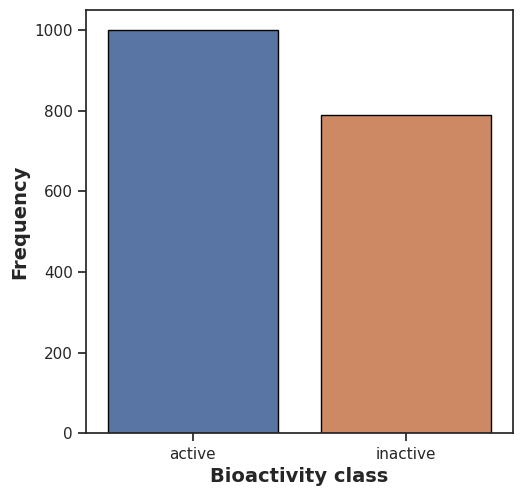

In [46]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=combined_compounds, edgecolor='black', hue='bioactivity_class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

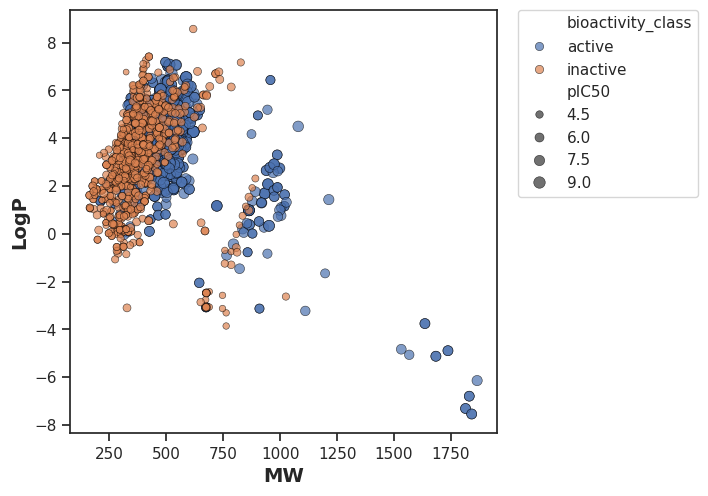

In [47]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=combined_compounds, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

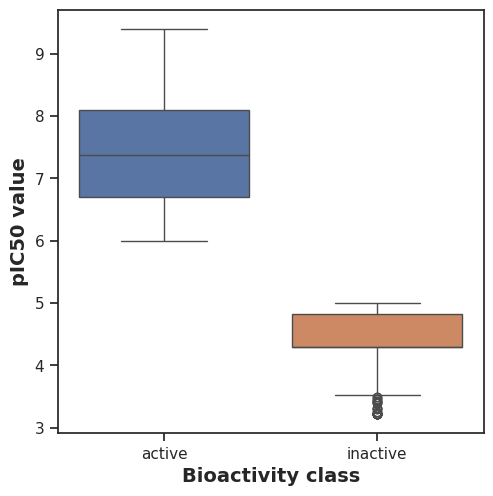

In [49]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = combined_compounds, hue='bioactivity_class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,57342159.0,0.0,0.05,Different distribution (reject H0)


#### **MW**

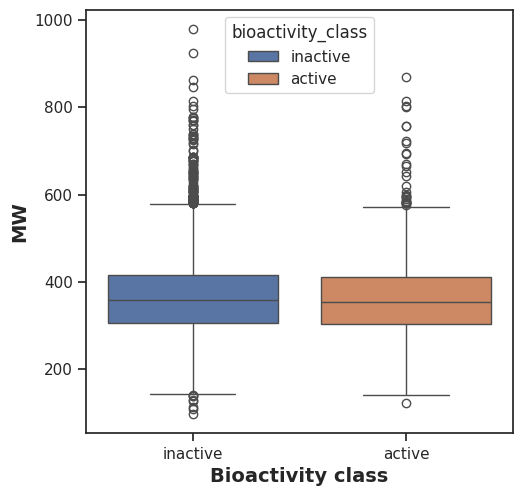

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class, hue='bioactivity_class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,732.0,0.746559,0.05,Same distribution (fail to reject H0)


#### **LogP**

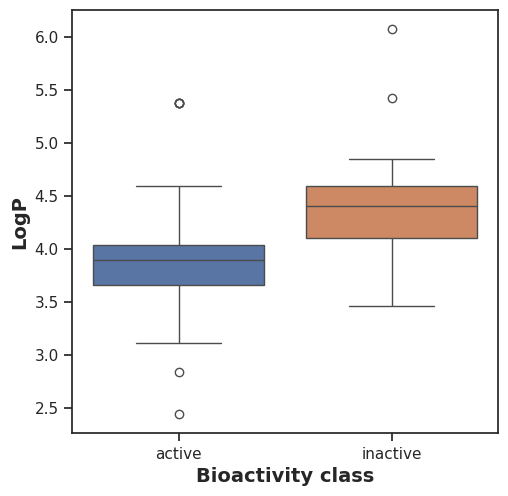

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class, hue='bioactivity_class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,269.5,0.000244,0.05,Different distribution (reject H0)


#### **NumHDonors**

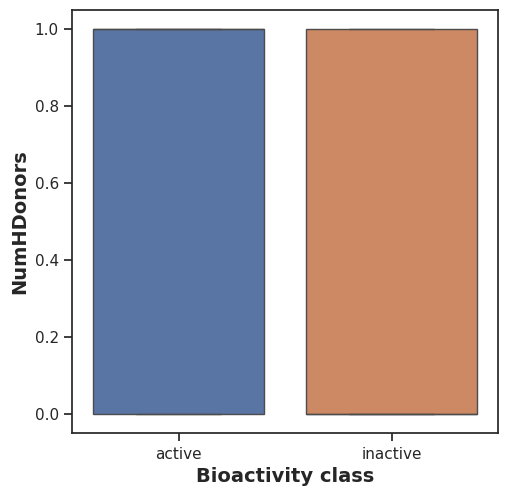

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class, hue='bioactivity_class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,664.5,0.359429,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

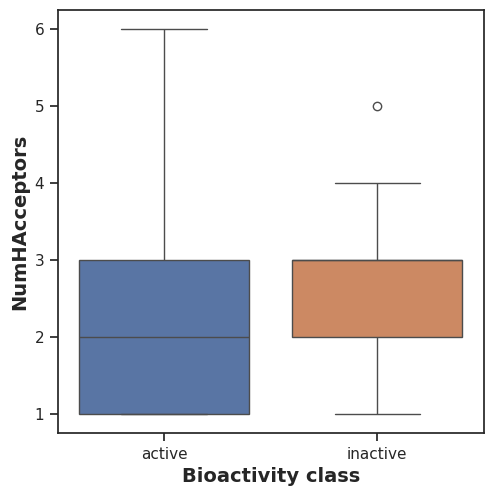

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class, hue='bioactivity_class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [ ]:
mannwhitney('NumHAcceptors')

NameError: name 'mannwhitney' is not defined

#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited ***no difference*** between the **actives** and **inactives** while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) shows ***statistically significant difference*** between **actives** and **inactives**.

## **Zip files**

In [ ]:
! zip -r results.zip . -i *.csv *.pdf

updating: bioactivity_data_preprocessed.csv (deflated 80%)
updating: plot_MW_vs_LogP.pdf (deflated 15%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: mannwhitneyu_pIC50.csv (deflated 11%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 9%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: mannwhitneyu_LogP.csv (deflated 8%)
  adding: plot_LogP.pdf (deflated 38%)
  adding: plot_ic50.pdf (deflated 38%)
  adding: plot_NumHAcceptors.pdf (deflated 37%)
  adding: plot_MW.pdf (deflated 37%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
